<a href="https://colab.research.google.com/github/nick01as/CLIP-dissect/blob/main/experiments/Project_Experiments/Analyzing_Compositions/Fig10_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect
!pip install ftfy regex

fatal: destination path 'CLIP-dissect' already exists and is not an empty directory.


In [2]:
import os
#virtually move to parent directory
os.chdir("CLIP-dissect")

import torch
from itertools import permutations
from matplotlib import pyplot as plt

import clip
import utils
import data_utils
import similarity

In [3]:
!pip install -r requirements.txt

In [4]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer4'
d_probe = 'cifar100_train'
concept_set = 'data/20k.txt'

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

In [5]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

with open(concept_set, 'r') as f:
    words = f.read().split('\n')

pil_data = data_utils.get_data(d_probe)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 2048/2048 [00:10<00:00, 192.49it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [00:05<00:00, 357.85it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:264
Top:1, Orig:vehicle, New:dewalt buses
Top:2, Orig:loader, New:loader bus


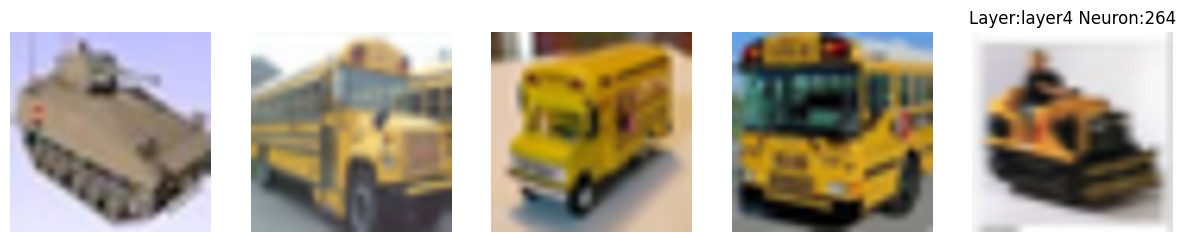

100%|██████████| 2048/2048 [00:09<00:00, 207.72it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [00:06<00:00, 316.46it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:543
Top:1, Orig:apples, New:pear varieties
Top:2, Orig:pear, New:patrol apples


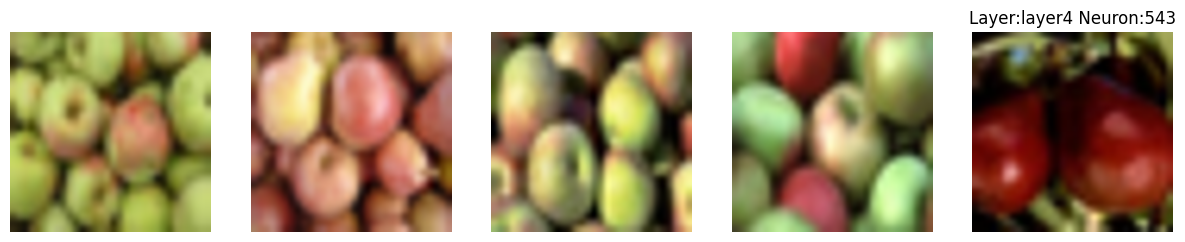

100%|██████████| 2048/2048 [00:10<00:00, 189.55it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [00:05<00:00, 378.24it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:880
Top:1, Orig:fox, New:paintball fox
Top:2, Orig:basename, New:scouts fox


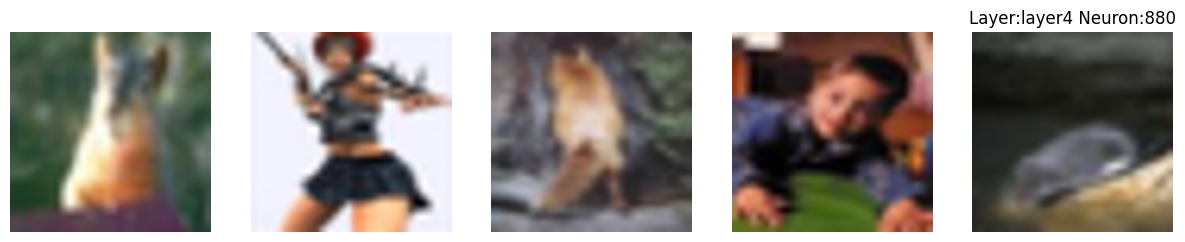

100%|██████████| 2048/2048 [00:10<00:00, 187.99it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [00:05<00:00, 365.70it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:470
Top:1, Orig:upholstery, New:upholstery fern
Top:2, Orig:chair, New:fern chair


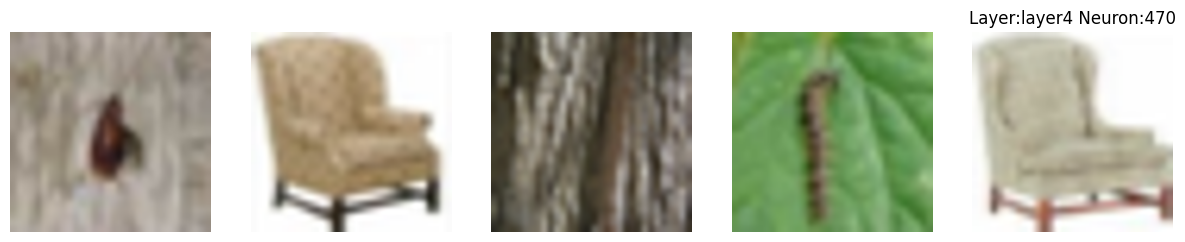

100%|██████████| 2048/2048 [00:11<00:00, 173.43it/s]


torch.Size([2048, 20000])


100%|██████████| 2048/2048 [00:05<00:00, 348.40it/s]


torch.Size([2048, 10000])

 Layer:layer4 Neuron:1154
Top:1, Orig:orange, New:orange collagen
Top:2, Orig:garrison, New:roses orange


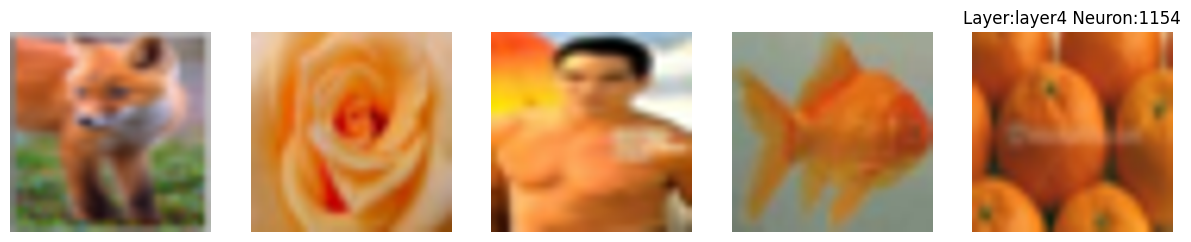

In [14]:
import random

clip_model, clip_preprocess = clip.load(clip_name, device=device)
ids_of_interest = random.sample(range(0, 1300), 5)

res_label = {id : [] for id in ids_of_interest}
res_image = {id : [] for id in ids_of_interest}

for id_of_interest in ids_of_interest:
    similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                       text_save_name, similarity_fn, device=device)
    target_feats = target_feats.cpu()
    vals, ids = torch.topk(similarities[id_of_interest], k=5, largest=True)
    orig_words = [words[int(ids[i])] for i in range(len(vals))]

    vals, ids = similarities[id_of_interest].topk(100, largest=True)
    del similarities
    torch.cuda.empty_cache()

    #create new concept set
    top_words = [words[ind] for ind in ids]

    new_words = permutations(top_words, r=2)
    new_words = [word1+' '+word2 for word1, word2 in new_words]
    new_words.extend(top_words)

    #recalculate similarities
    text = clip.tokenize(["{}".format(word) for word in new_words]).to(device)
    with torch.no_grad():
        image_features = torch.load(clip_save_name)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_features = utils.get_clip_text_features(clip_model, text, batch_size=1000)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    clip_feats = (image_features @ text_features.T).cpu().float()

    del image_features, text_features
    torch.cuda.empty_cache()

    similarities = similarity_fn(clip_feats, target_feats)
    top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(id_of_interest))))

    vals, ids = torch.topk(similarities[id_of_interest], k=2, largest=True)
    del similarities, clip_feats
    torch.cuda.empty_cache()

    res_label[int(id_of_interest)].append(new_words[int(ids[0])])

    for i in range(len(vals)):
        print("Top:{}, Orig:{}, New:{}".format(i+1, orig_words[i], new_words[int(ids[i])]))


    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, id_of_interest]):
        res_image[int(id_of_interest)].append(top_id)
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')

    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(id_of_interest))))
    plt.show()

In [9]:
from PIL import Image
!pip install -U sentence-transformers
!pip install transformers==4.28.0
from sentence_transformers import SentenceTransformer
from transformers import pipeline
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")


model = SentenceTransformer('all-mpnet-base-v2')
clip_name = 'ViT-B/16'
clip_model, _ = clip.load(clip_name, device=device)
import math

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
random_word = "sweet potato"
test_word1 = "cat"
test_word2 = "dog"

for ids in ids_of_interest:

  avg_clip = 0
  word1_clip_avg = 0
  word2_clip_avg = 0
  rand_word_clip_avg = 0
  comb_word_clip_avg = 0
  conjunc1_word_clip_avg = 0
  conjunc2_word_clip_avg = 0
  rev1_word_clip_avg = 0
  rev2_word_clip_avg = 0

  avg_mpnet = 0
  word1_mpnet_avg = 0
  word2_mpnet_avg = 0
  rand_word_mpnet_avg = 0
  comb_word_mpnet_avg = 0
  conjunc1_word_mpnet_avg = 0
  conjunc2_word_mpnet_avg = 0
  rev1_word_mpnet_avg = 0
  rev2_word_mpnet_avg = 0

  print('Neuron #{}: '.format(ids))

  for i, im_id in enumerate(res_image[ids]):
    im, label = pil_data[im_id]
    extract_text = image_to_text(im)[0]['generated_text']

    clip_text = res_label[ids][0]

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, clip_text, clip_model, model, device, batch_size)
    avg_clip += clip_cos
    avg_mpnet += mpnet_cos
    if i == 0: print('Original Composition: {}'.format(clip_text))

    clip_text = clip_text.split()
    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, clip_text[0], clip_model, model, device, batch_size)
    word1_clip_avg += clip_cos
    word1_mpnet_avg += mpnet_cos
    if i == 0: print('Word 1: {}'.format(clip_text[0]))

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, clip_text[1], clip_model, model, device, batch_size)
    word2_clip_avg += clip_cos
    word2_mpnet_avg += mpnet_cos
    if i == 0: print('Word 2: {}'.format(clip_text[1]))

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, random_word, clip_model, model, device, batch_size)
    rand_word_clip_avg += clip_cos
    rand_word_mpnet_avg += mpnet_cos
    if i == 0: print('Random Word: {}'.format(random_word))

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, (random_word + ' ' + clip_text[0]), clip_model, model, device, batch_size)
    comb_word_clip_avg += clip_cos
    comb_word_mpnet_avg += mpnet_cos
    if i == 0: print('Random Word + Word 1: {}'.format(random_word + ' ' + clip_text[0]))

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, (clip_text[0] + ' ' + clip_text[1] + ' and ' + random_word), clip_model, model, device, batch_size)
    conjunc2_word_clip_avg += clip_cos
    conjunc2_word_mpnet_avg += mpnet_cos
    if i == 0: print('Orig Composition + and + Random Word (Wrong Logic): {}'.format(clip_text[0] + ' ' + clip_text[1] + ' and ' + random_word))

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, (clip_text[0] + ' ' + clip_text[1] + ' and not ' + random_word), clip_model, model, device, batch_size)
    conjunc1_word_clip_avg += clip_cos
    conjunc1_word_mpnet_avg += mpnet_cos
    if i == 0: print('Orig Composition + not + Random Word: {}'.format(clip_text[0] + ' ' + clip_text[1] + ' and not ' + random_word))

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, (test_word1 + ' and ' + test_word2), clip_model, model, device, batch_size)
    rev1_word_clip_avg += clip_cos
    rev1_word_mpnet_avg += mpnet_cos
    if i == 0: print('Test 1: Cat + Dog: {}'.format(test_word1 + ' and ' + test_word2))

    clip_cos, mpnet_cos = utils.get_cos_similarity(extract_text, (test_word2 + ' and ' + test_word1), clip_model, model, device, batch_size)
    rev2_word_clip_avg += clip_cos
    rev2_word_mpnet_avg += mpnet_cos
    if i == 0: print('Test 2: Dog + Cat: {}\n'.format(test_word2 + ' and ' + test_word1))

    print("Image {} Extracted Text: {}".format(i+1, extract_text))


  avg_clip /= len(res_image[ids])
  word1_clip_avg /= len(res_image[ids])
  word2_clip_avg /= len(res_image[ids])
  rand_word_clip_avg /= len(res_image[ids])
  comb_word_clip_avg /= len(res_image[ids])
  conjunc1_word_clip_avg /= len(res_image[ids])
  conjunc2_word_clip_avg /= len(res_image[ids])
  rev1_word_clip_avg /= len(res_image[ids])
  rev2_word_clip_avg /= len(res_image[ids])

  avg_mpnet /= len(res_image[ids]) * 10
  word1_mpnet_avg /= len(res_image[ids]) * 10
  word2_mpnet_avg /= len(res_image[ids]) * 10
  rand_word_mpnet_avg /= len(res_image[ids]) * 10
  comb_word_mpnet_avg /= len(res_image[ids]) * 10
  conjunc1_word_mpnet_avg /= len(res_image[ids]) * 10
  conjunc2_word_mpnet_avg /= len(res_image[ids]) * 10
  rev1_word_mpnet_avg /= len(res_image[ids]) * 10
  rev2_word_mpnet_avg /= len(res_image[ids]) * 10

  print('\nOriginal Compisition average clip_sim: {}'.format(avg_clip))
  print('Word 1 average clip_sim: {}'.format(word1_clip_avg))
  print('Word 2 average clip_sim: {}'.format(word2_clip_avg))
  print('Random word average clip_sim: {}'.format(rand_word_clip_avg))
  print('Random Word + Word 1 average clip_sim: {}'.format(comb_word_clip_avg))
  print('Orig Composition + and + Random Word average clip_sim: {}'.format(conjunc2_word_clip_avg))
  print('Orig Composition + not + Random Word average clip_sim: {}'.format(conjunc1_word_clip_avg))
  print('Test 1: average clip_sim: {}'.format(rev1_word_clip_avg))
  print('Test 2: average clip_sim: {}'.format(rev2_word_clip_avg))
  print('Does reverse affect clip cosine sim?: {}'.format(not(abs(rev1_word_clip_avg - rev2_word_clip_avg) < 0.01)))

  print('\nOriginal Compisition average mpnet: {}'.format(avg_mpnet))
  print('Word 1 average mpnet: {}'.format(word1_mpnet_avg))
  print('Word 2 average mpnet: {}'.format(word2_mpnet_avg))
  print('Random word average mpnet: {}'.format(rand_word_mpnet_avg))
  print('Random Word + Word 1 average mpnet: {}'.format(comb_word_mpnet_avg))
  print('Orig Composition + and + Random Word average mpnet: {}'.format(conjunc2_word_mpnet_avg))
  print('Orig Composition + not + Random Word average mpnet: {}'.format(conjunc1_word_mpnet_avg))
  print('Test 1: average mpnet: {}'.format(rev1_word_mpnet_avg))
  print('Test 2: average mpnet: {}'.format(rev2_word_mpnet_avg))
  print('Does reverse affect mpnet cosine sim?: {}'.format(not(abs(rev1_word_mpnet_avg - rev2_word_mpnet_avg) < 0.01)))
  print('\n')





Neuron #264: 
Original Composition: dewalt buses
Word 1: dewalt
Word 2: buses
Random Word: sweet potato
Random Word + Word 1: sweet potato dewalt
Orig Composition + and + Random Word (Wrong Logic): dewalt buses and sweet potato
Orig Composition + not + Random Word: dewalt buses and not sweet potato
Test 1: Cat + Dog: cat and dog
Test 2: Dog + Cat: dog and cat

Image 1 Extracted Text: a large black and white model of a dog 
Image 2 Extracted Text: a school bus parked in a parking lot 
Image 3 Extracted Text: a yellow school bus parked in a parking lot 
Image 4 Extracted Text: a school bus is parked in a parking lot 
Image 5 Extracted Text: a toy train is shown in a picture 

Original Compisition average clip_sim: 0.6361328125
Word 1 average clip_sim: 0.580419921875
Word 2 average clip_sim: 0.70146484375
Random word average clip_sim: 0.574609375
Random Word + Word 1 average clip_sim: 0.51806640625
Orig Composition + and + Random Word average clip_sim: 0.5642578125
Orig Composition + not 